In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
import time

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [4]:
# create engine to hawaii.sqlite - ensure hawaii.sqlite is already in place (in the same folder level as this file), or a new, blank file will be created
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create inspector to get a list of column names and types for the two tables
inspector = inspect(engine)

In [9]:
# Column names and types for "Station"
Station_cols = inspector.get_columns('station')

for c in Station_cols:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Column names and types for "Measurement"
Measurement_cols = inspector.get_columns('measurement')

for c in Measurement_cols:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

print(f" The most recent date in the dataset is {last_date}.")

 The most recent date in the dataset is 2017-08-23.


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one non leap-year from the last date in data set. strptime converts a string to datetime. strftime converts datetime to string
date_format = "%Y-%m-%d"
nonleap_year = 365
query_date = dt.datetime.strptime(last_date, date_format) - dt.timedelta(days=nonleap_year)

# Perform a query to retrieve the data and precipitation scores
date_and_prcp = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date > query_date).all()

# Save the query results (a list) as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(date_and_prcp, columns=["Date", "Precipitation (in)"])
prcp_df = prcp_df.set_index("Date")

# Sort the dataframe by date
prcp_df = prcp_df.sort_index(ascending = True)

# Display the data frame
prcp_df

,Precipitation (in)
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


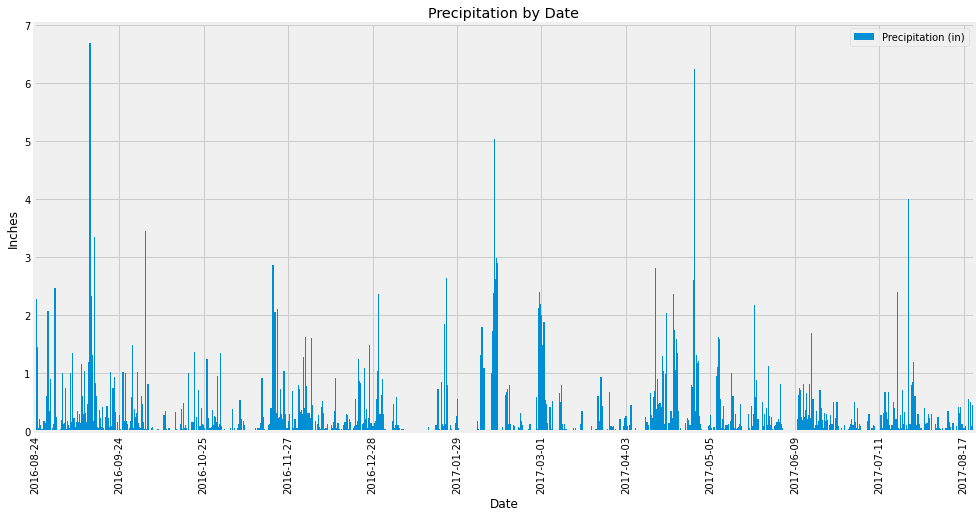

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.bar(figsize=(15, 7.5), width = 3)
plt.ylabel("Inches")
plt.title("Precipitation by Date")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12)) # gca is used to "Get Current Axes" to use xaxis.etc to reduce the number of xticks

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_stats = round(prcp_df[["Precipitation (in)"]].describe(), 2)
prcp_stats

,Precipitation (in)
count,2015.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.station).distinct().count()
print(f"There are {station_count} stations in the data set.")

There are 9 stations in the data set.


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station).label("Total"))\
                            .group_by(Measurement.station)\
                            .order_by(desc("Total")).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = max(station_activity, key=lambda x:x[1])

lowest_temp = session.query(func.min(Measurement.tobs))\
                            .filter(Measurement.station == active_station[0]).scalar()

highest_temp = session.query(func.max(Measurement.tobs))\
                            .filter(Measurement.station == active_station[0]).scalar()

average_temp = session.query(func.avg(Measurement.tobs))\
                            .filter(Measurement.station == active_station[0]).scalar()

# Create data frame for the temperature data
data = {"Type":["Lowest", "Highest", "Average"], "Temperatures (F)": [lowest_temp, highest_temp, average_temp]}

act_station_temps = pd.DataFrame(data)
act_station_temps["Temperatures (F)"] = round(act_station_temps["Temperatures (F)"], 2)
act_station_temps = act_station_temps.set_index("Type")

print(f" The most active station is {active_station[0]}, with {active_station[1]} readings.")
act_station_temps

 The most active station is USC00519281, with 2772 readings.


,Temperatures (F)
Type,
Lowest,54.00
Highest,85.00
Average,71.66


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date_and_tobs = session.query(Measurement.date, Measurement.tobs)\
                    .filter(Measurement.date > query_date)\
                    .filter(Measurement.station == active_station[0]).all()

# Save the query results (a list) as a Pandas DataFrame and set the index to the date column
tobs_df = pd.DataFrame(date_and_tobs, columns=["Date", "Temperature (F)"])
tobs_df = tobs_df.set_index("Date")

# Sort the dataframe by date
tobs_df = tobs_df.sort_index(ascending = True)

# Display the data frame
tobs_df

,Temperature (F)
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


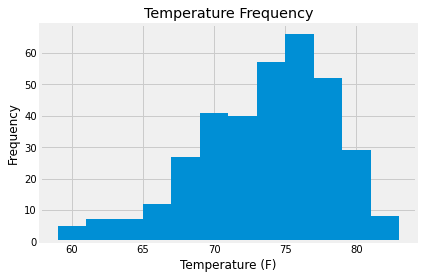

In [20]:
tobs_df.plot.hist(bins = 12, legend = False)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title("Temperature Frequency");

In [32]:
# Return a JSON list of stations from the dataset

station_names = session.query(Station.name).all()
station_names

[('WAIKIKI 717.2, HI US',),
 ('KANEOHE 838.1, HI US',),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',),
 ('PEARL CITY, HI US',),
 ('UPPER WAHIAWA 874.3, HI US',),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',),
 ('WAIHEE 837.5, HI US',),
 ('HONOLULU OBSERVATORY 702.2, HI US',),
 ('MANOA LYON ARBO 785.2, HI US',)]

# Close session

In [30]:
# Close Session
session.close()